In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
f1 = open("data/choi/1/3-11/0.ref", "r")
print(f1.read())

Santa Barbara -- `` The present recovery movement will gather steady momentum to lift the economy to a new historic peak by this autumn '' , Beryl W. Sprinkel , economist of Harris Trust & Savings Bank , Chicago , predicted at the closing session here Tuesday of Investment Bankers Assn. , California group , conference . 
Another speaker , William H. Draper , Jr. , former Under Secretary of the Army and now with the Palo Alto venture capital firm of Draper , Gaither & Anderson , urged the U.S. to `` throw down the gauntlet of battle to communism and tell Moscow bluntly we wo n't be pushed around any more '' . 
He urged support for President Kennedy 's requests for both defense and foreign aid appropriations . 
' not flash in pan ' Sprinkel told conferees that the recent improvement in economic activity was not a `` temporary flash in the pan '' but the beginning of a substantial cyclical expansion that will carry the economy back to full employment levels and witness a renewal of our tr

In [3]:
# Read the content of the .txt file
file_path = "data/choi/1/3-11/0.ref"  # Replace with the actual file path
with open(file_path, "r") as file:
    segmented_text = file.read()

# Split the text by "=========" to get individual segments
segments = segmented_text.split("==========")

# Remove any leading/trailing whitespace from each segment and join them together
united_text = " ".join(segment.strip() for segment in segments)

# print(united_text)


## Join segmented text and make united text and save it on data/united_text

In [4]:
import os

input_directory = "data/choi"
output_directory = "data/united_texts"

# Create the output directory
os.makedirs(output_directory, exist_ok=True)

# Read all .ref files in input_directory
for root, dirs, files in os.walk(input_directory):
    for filename in files:
        if filename.endswith(".ref"):
            file_path = os.path.join(root, filename)
            with open(file_path, "r") as file:
                segmented_text = file.read()

            # Split the text by "=========" 
            segments = segmented_text.split("==========")

            # Remove any whitespace from each segment and join them together
            united_text = " ".join(segment.strip() for segment in segments)

            # Create the output file path for the united_text
            relative_path = os.path.relpath(file_path, input_directory)
            output_file_path = os.path.join(output_directory, relative_path)

            os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

            # Write the united text to the output file
            with open(output_file_path, "w") as output_file:
                output_file.write(united_text)


## Create a dataset contain a column for united_text and a column for segmented text

In [4]:
choi_folder_path = "data/choi"

# Function to extract segments from a file
def extract_segments(file_path):
    with open(file_path, "r") as file:
        segmented_text = file.read()

    # Split the text by "==========" 
    segments = segmented_text.strip().split("==========")

    # Remove any  whitespace from each segment and remove empty segments
    segments = [segment.strip() for segment in segments if segment.strip()]
    
    return segments

data = []

for root, _, files in os.walk(choi_folder_path):
    for file in files:
        if file.endswith(".ref"):
            file_path = os.path.join(root, file)
            segments = extract_segments(file_path)
            united_text = " ".join(segments)  
            data.append({
                "File": file_path,
                "Number of segments": len(segments),
                "segments": segments,
                "united_text": united_text
            })

df = pd.DataFrame(data)


# df.to_csv("segments_data_with_united_text.csv", index=False)

df.head()


,File,Number of segments,segments,united_text
0,data/choi\1\3-11\0.ref,10,[Santa Barbara -- `` The present recovery move...,Santa Barbara -- `` The present recovery movem...
1,data/choi\1\3-11\1.ref,10,[The vast Central Valley of California is one ...,The vast Central Valley of California is one o...
2,data/choi\1\3-11\10.ref,10,[The bronchus and pulmonary artery in this lun...,The bronchus and pulmonary artery in this lung...
3,data/choi\1\3-11\11.ref,10,[The Fulton County Grand Jury said Friday an i...,The Fulton County Grand Jury said Friday an in...
4,data/choi\1\3-11\12.ref,10,[Temperature of the wash and rinse waters is m...,Temperature of the wash and rinse waters is ma...


In [5]:
df.isnull().sum()

File                  0
Number of segments    0
segments              0
united_text           0
dtype: int64

In [6]:
df.shape

(920, 4)

In [7]:
df.dtypes

File                  object
Number of segments     int64
segments              object
united_text           object
dtype: object

# Text similarity with NLTK (Lexical)

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def sentence_similarity_NLTK(text):
    # Split the text into sentences
    sentences = sent_tokenize(text)

    # Tokenize and lemmatize the sentences
    lemmatizer = WordNetLemmatizer()
    tokenized_sentences = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        tokenized_sentences.append(tokens)

    # Remove stopwords
    stop_words = stopwords.words('english')
    filtered_sentences = []
    for tokens in tokenized_sentences:
        filtered_sentence = [token for token in tokens if token not in stop_words]
        filtered_sentences.append(filtered_sentence)

    # Create the TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_vectors = vectorizer.fit_transform([' '.join(sentence) for sentence in filtered_sentences])

    # Calculate the cosine similarity for each pair of sentences
    similarity_scores = cosine_similarity(tfidf_vectors)

    # Get the similarity scores 
    similarity_results = []
    num_sentences = len(sentences)
    for i in range(num_sentences):
        for j in range(i + 1, num_sentences):
            similarity_score = similarity_scores[i][j]
            similarity_results.append((i, j, round(similarity_score, 3)))

    return similarity_results

# Text Segmentation Function

In [9]:
segments = df['segments'][0]
united_text = df['united_text'][0]

In [10]:
def sentence_segmentation_NLTK(text, num_tiles=10, threshold=0.5):
    similarity_results = sentence_similarity_NLTK(text)

    # Split the text into sentences
    sentences = sent_tokenize(text)

    # Check if there are any similarity scores above the threshold
    if not any(score >= threshold for _, _, score in similarity_results):
        return [' '.join(sentences)]

    segments = []
    num_sentences = len(sentences)
    segment = [0]
    for i in range(1, num_sentences):
        if similarity_results[i - 1][2] >= threshold:
            segment.append(i)
        else:
            segments.append(segment)
            segment = [i]
    segments.append(segment)

    # Sort the segments based on their average similarity score 
    segments.sort(key=lambda x: sum(similarity_results[i][2] for i in x) / len(x), reverse=True)

    # Get the top 'num_tiles' segments 
    if num_tiles is not None:
        segments = segments[:num_tiles]

    segments.sort(key=lambda x: x[0])

    # Return the segmented text
    segmented_text = [' '.join(sentences[start:end + 1]) for segment in segments for start, end in [(segment[0], segment[-1])]]
    return segmented_text

In [11]:
example_1 = sentence_segmentation_NLTK(united_text, num_tiles=10, threshold=0.5)

In [12]:
len(example_1)

1

In [13]:
example_2 = sentence_segmentation_NLTK(united_text, num_tiles=10, threshold=0.46)

In [14]:
len(example_2)

10

## Find Best Threshold

In [15]:
# Loop through different threshold values
best_threshold = None
best_similarity = 0.0

# Define threshold
threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for threshold_value in threshold:
    # Apply the sentence_segmentation_NLTK function
    segmented_text = sentence_segmentation_NLTK(united_text, num_tiles=10, threshold=threshold_value)
        
    # Calculate similarity using Cosine Similarity
    vectorizer = TfidfVectorizer().fit_transform(segments + segmented_text)
    similarity_matrix = cosine_similarity(vectorizer)
        
    # Calculate average similarity between actual segments and segmented text
    avg_similarity = similarity_matrix[:len(segments), len(segments):].mean()
        
    # Update best threshold if higher similarity is found
    if avg_similarity > best_similarity:
        best_similarity = avg_similarity
        best_threshold = threshold_value

print(best_threshold, best_similarity)

0.5 0.5512496908902533


## Function to find best threshold

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def tune_threshold_for_dataset(segments, united_text):
    
    # Loop through different threshold values
    best_threshold = None
    best_similarity = 0.0


    threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for threshold_value in threshold:
        # Apply the sentence_segmentation_NLTK function
        segmented_text = sentence_segmentation_NLTK(united_text, num_tiles=10, threshold=threshold_value)
        
        # Calculate similarity 
        vectorizer = TfidfVectorizer().fit_transform(segments + segmented_text)
        similarity_matrix = cosine_similarity(vectorizer)
        
        # Calculate average similarity between actual segments and segmented text
        avg_similarity = similarity_matrix[:len(segments), len(segments):].mean()
        
        # Update best threshold
        if avg_similarity > best_similarity:
            best_similarity = avg_similarity
            best_threshold = threshold_value

    return best_threshold, best_similarity

In [31]:
best_thresholds = []
best_similarities = []

# Iterate through rows
for index, row in df.iterrows():
    segments = row['segments']
    united_text = row['united_text']

    # Call the function
    best_threshold, best_similarity = tune_threshold_for_dataset(segments, united_text)

    best_thresholds.append(best_threshold)
    best_similarities.append(best_similarity)

In [32]:
df['best_threshold'] = best_thresholds
df['best_similarity'] = best_similarities

In [33]:
df.head()

,File,Number of segments,segments,united_text,best_threshold,best_similarity
0,data/choi\1\3-11\0.ref,10,[Santa Barbara -- `` The present recovery move...,Santa Barbara -- `` The present recovery movem...,0.5,0.551250
1,data/choi\1\3-11\1.ref,10,[The vast Central Valley of California is one ...,The vast Central Valley of California is one o...,0.6,0.605006
2,data/choi\1\3-11\10.ref,10,[The bronchus and pulmonary artery in this lun...,The bronchus and pulmonary artery in this lung...,0.5,0.557801
3,data/choi\1\3-11\11.ref,10,[The Fulton County Grand Jury said Friday an i...,The Fulton County Grand Jury said Friday an in...,0.1,0.163308
4,data/choi\1\3-11\12.ref,10,[Temperature of the wash and rinse waters is m...,Temperature of the wash and rinse waters is ma...,0.1,0.120461


## Probability distribution for best threshold

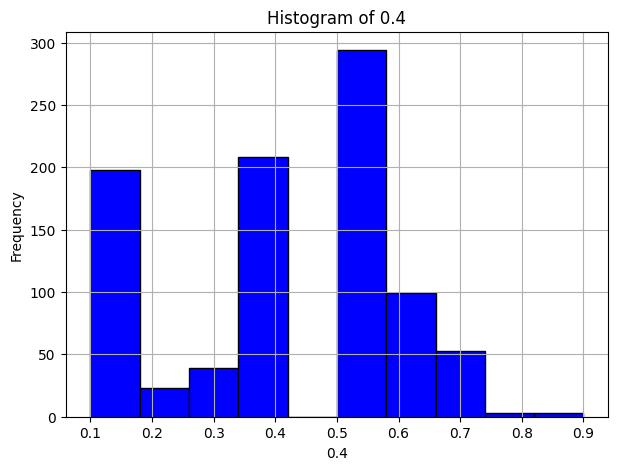

In [34]:
import matplotlib.pyplot as plt

# Create a histogram
plt.figure(figsize=(7, 5))  
plt.hist(df['best_threshold'], bins=10, color='blue', edgecolor='black')  
plt.title(f"Histogram of {best_threshold}")
plt.xlabel(best_threshold)
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [17]:
def evaluate_segmentation_with_placement(true_boundaries, predicted_boundaries, tolerance=2):

    true_positives = 0

    false_positives = 0

    false_negatives = 0

 

    for pred_boundary in predicted_boundaries:

        closest_true_boundary = min(true_boundaries, key=lambda x: abs(x - pred_boundary))

        if abs(closest_true_boundary - pred_boundary) <= tolerance:

            true_positives += 1

            true_boundaries.remove(closest_true_boundary)

        else:

            false_positives += 1

 

    false_negatives = len(true_boundaries)

 

    accuracy = true_positives / len(predicted_boundaries)

    precision = true_positives / (true_positives + false_positives)

    recall = true_positives / (true_positives + false_negatives)

 

    return accuracy, precision, recall

In [18]:
def calculate_true_boundaries(actual_segments):
    true_boundaries = []
    current_index = 0
    for segment in actual_segments:
        current_index += len(segment) + 1  # Add 1 for the period at the end of the sentence
        true_boundaries.append(current_index - 1)  # Subtract 1 to get the index of the period
    return true_boundaries

def calculate_predicted_boundaries(segmented_text):
    predicted_boundaries = []
    current_index = 0
    for segment in segmented_text:
        current_index += len(segment) + 1  # Add 1 for the period at the end of the sentence
        predicted_boundaries.append(current_index - 1)  # Subtract 1 to get the index of the period
    return predicted_boundaries


In [19]:
actual_segments = df['segments'][0]
united_text = df['united_text'][0]
segmented_text = sentence_segmentation_NLTK(united_text, num_tiles=10, threshold=0.45)

In [20]:
calculate_true_boundaries(actual_segments)

[1297, 1934, 2615, 3426, 4580, 5165, 6145, 7604, 8204, 9816]

In [21]:
len(calculate_true_boundaries(actual_segments))

10

In [22]:
calculate_predicted_boundaries(segmented_text)

[103, 373, 478, 493, 625, 784, 893, 1037, 1137, 1289]

In [23]:
len(calculate_predicted_boundaries(segmented_text))

10

In [24]:
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Example threshold values to test

for threshold in thresholds_to_test:
    segmented_text = sentence_segmentation_NLTK(united_text, num_tiles=10, threshold=threshold)
    
    true_boundaries = calculate_true_boundaries(actual_segments)
    predicted_boundaries = calculate_predicted_boundaries(segmented_text)
    
    accuracy, precision, recall = evaluate_segmentation_with_placement(true_boundaries, predicted_boundaries)
    
    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print()


Threshold: 0.1
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.2
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.3
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.4
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.5
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.6
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.7
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.8
Accuracy: 0.0
Precision: 0.0
Recall: 0.0

Threshold: 0.9
Accuracy: 0.0
Precision: 0.0
Recall: 0.0



In [25]:
def evaluate_segmentation_for_segment(segment, threshold):
    segmented_text = sentence_segmentation_NLTK(segment, num_tiles=10, threshold=threshold)
    
    true_boundaries = calculate_true_boundaries(segment)
    predicted_boundaries = calculate_predicted_boundaries(segmented_text)
    
    accuracy, precision, recall = evaluate_segmentation_with_placement(true_boundaries, predicted_boundaries)
    
    return accuracy, precision, recall

In [26]:
thresholds_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds_to_test:
    df[f'Threshold_{threshold}_Accuracy'], df[f'Threshold_{threshold}_Precision'], df[f'Threshold_{threshold}_Recall'] = zip(*df['united_text'].apply(lambda x: evaluate_segmentation_for_segment(x, threshold)))


## Suspicious Result!!!

In [28]:
df.head()

,File,Number of segments,segments,united_text,Threshold_0.1_Accuracy,Threshold_0.1_Precision,Threshold_0.1_Recall,Threshold_0.2_Accuracy,Threshold_0.2_Precision,Threshold_0.2_Recall,...,Threshold_0.6_Recall,Threshold_0.7_Accuracy,Threshold_0.7_Precision,Threshold_0.7_Recall,Threshold_0.8_Accuracy,Threshold_0.8_Precision,Threshold_0.8_Recall,Threshold_0.9_Accuracy,Threshold_0.9_Precision,Threshold_0.9_Recall
0,data/choi\1\3-11\0.ref,10,[Santa Barbara -- `` The present recovery move...,Santa Barbara -- `` The present recovery movem...,1.0,1.0,0.001019,1.0,1.0,0.001019,...,0.000102,1.0,1.0,0.000102,1.0,1.0,0.000102,1.0,1.0,0.000102
1,data/choi\1\3-11\1.ref,10,[The vast Central Valley of California is one ...,The vast Central Valley of California is one o...,1.0,1.0,0.000750,1.0,1.0,0.000750,...,0.000075,1.0,1.0,0.000075,1.0,1.0,0.000075,1.0,1.0,0.000075
2,data/choi\1\3-11\10.ref,10,[The bronchus and pulmonary artery in this lun...,The bronchus and pulmonary artery in this lung...,1.0,1.0,0.000885,1.0,1.0,0.000885,...,0.000089,1.0,1.0,0.000089,1.0,1.0,0.000089,1.0,1.0,0.000089
3,data/choi\1\3-11\11.ref,10,[The Fulton County Grand Jury said Friday an i...,The Fulton County Grand Jury said Friday an in...,1.0,1.0,0.001330,1.0,1.0,0.001330,...,0.001330,1.0,1.0,0.001330,1.0,1.0,0.001330,1.0,1.0,0.001330
4,data/choi\1\3-11\12.ref,10,[Temperature of the wash and rinse waters is m...,Temperature of the wash and rinse waters is ma...,1.0,1.0,0.000799,1.0,1.0,0.000799,...,0.000799,1.0,1.0,0.000799,1.0,1.0,0.000799,1.0,1.0,0.000799


In [29]:
df['Threshold_0.5_Precision'][0]

1.0

## Find Similarity score for dataset

In [33]:
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics import f1_score

def calculate_boundary_similarity(true_boundaries, predicted_boundaries):
    intersection = len(set(true_boundaries) & set(predicted_boundaries))
    union = len(set(true_boundaries) | set(predicted_boundaries))
    return intersection / union

# Define the range of thresholds to try
thresholds_to_try = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

best_threshold = None
best_score = 0

for threshold in thresholds_to_try:
    predicted_boundaries_list = []  # Store predicted boundaries for this threshold
    true_boundaries_list = []  # Store true boundaries for each united_text
    
    for united_text, true_segments in zip(df['united_text'], df['segments']):
        segmented_text = sentence_segmentation_NLTK(united_text, threshold=threshold)
        
        # Convert segmented_text into segment boundaries using character positions
        predicted_segment_boundaries = calculate_predicted_boundaries(segmented_text)
        
        # Convert true_segments into corresponding segment boundaries
        true_segment_boundaries = calculate_true_boundaries(true_segments)
        
        # Append boundaries to lists
        predicted_boundaries_list.append(predicted_segment_boundaries)
        true_boundaries_list.append(true_segment_boundaries)
    
    # Calculate the evaluation score for this threshold
    score = 0.0  # Initialize BSS score
    
    for true_boundaries, predicted_boundaries in zip(true_boundaries_list, predicted_boundaries_list):
        score += calculate_boundary_similarity(true_boundaries, predicted_boundaries)
    
    score /= len(true_boundaries_list)  # Average BSS score across all texts
    
    if score > best_score:
        best_score = score
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best Boundary Similarity Score:", best_score)


Best Threshold: 0.3
Best Boundary Similarity Score: 0.0005148741418764302
